In [1]:
import scarches as sca
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import pandas as pd
import os
import sys
import importlib

Using TensorFlow backend.


In [2]:
sys.path.insert(0, "../lib")

In [3]:
import sc_utils

In [5]:
pd.set_option('display.max_rows', 1000)

In [6]:
mpl.rcParams["figure.figsize"] = (14, 12)

In [7]:
latent = sc.read_h5ad("../data/03ipf_projection/01latent2.h5ad")

In [8]:
combined = sc.read_h5ad("../data/03ipf_projection/01combined.h5ad")

In [9]:
latent.obs.population.value_counts()

Immune-TX         76534
Immune            61393
Epithelial        37325
Epithelial-TX     32416
Stromal-TX        31032
Endothelial-TX    15431
Endothelial       10446
Mesenchymal        5232
Name: population, dtype: int64

In [10]:
latent = latent[latent.obs.population.isin(["Immune", "Immune-TX"]), ]
imm = combined[combined.obs.population.isin(["Immune", "Immune-TX"]), ]

In [11]:
latent.shape

(137927, 10)

In [12]:
imm.shape

(137927, 19202)

In [13]:
imm.obs.celltype.value_counts()

Macrophages                  38928
MoAM-1                       17395
TRAM-1                       15548
T cells                      11255
MoAM-2                       10032
Plasma cells                  9322
Monocytes                     6765
MoAM-3                        6299
TRAM-2                        6003
TRAM-3                        4024
B cells                       2381
NK cells                      2322
cDCs                          2132
Proliferating Macrophages     1563
DCs                           1556
Mast cells                    1453
Proliferating T cells          490
MoAM-4                         271
pDCs                           188
Name: celltype, dtype: int64

Keep only Macrophages and Monocytes

In [14]:
to_keep = ["Macrophages", "MoAM-1", "TRAM-1", "MoAM-2", "Monocytes", 
           "MoAM-3", "TRAM-2", "TRAM-3", "Proliferating Macrophages",
           "MoAM-4"]

In [15]:
cells_to_keep = imm.obs.celltype.isin(to_keep)
imm = imm[cells_to_keep, :]
latent = latent[cells_to_keep, :]

In [16]:
imm.shape

(106828, 19202)

In [17]:
sc.tl.leiden(latent, resolution=0.2)

Trying to set attribute `.obs` of view, copying.


In [18]:
imm.obs["leiden"] = latent.obs.leiden

Trying to set attribute `.obs` of view, copying.


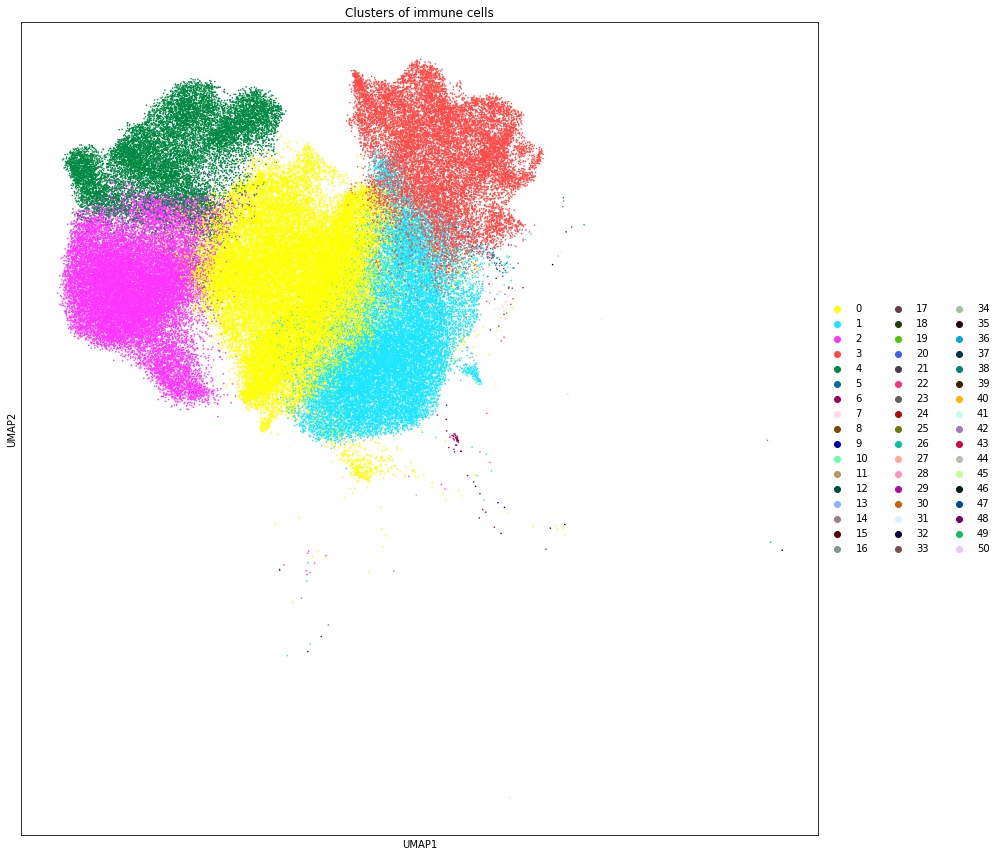

In [19]:
ax = sc.pl.umap(
    imm, 
    color="leiden",
    size=10, 
    title="Clusters of immune cells",
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()

In [20]:
leiden_size = imm.obs.leiden.value_counts()

In [21]:
leiden_size

0     32682
1     22718
2     22680
3     15317
4     13261
5        55
6        40
7        23
12        2
16        2
15        2
14        2
13        2
11        2
10        2
9         2
8         2
24        1
17        1
18        1
19        1
20        1
21        1
22        1
23        1
50        1
49        1
38        1
48        1
47        1
46        1
45        1
44        1
43        1
42        1
41        1
40        1
39        1
37        1
26        1
36        1
35        1
34        1
33        1
32        1
31        1
30        1
29        1
28        1
27        1
25        1
Name: leiden, dtype: int64

In [22]:
latent = latent[~latent.obs.leiden.isin(leiden_size.index[leiden_size <= 3]), :]
imm = imm[~imm.obs.leiden.isin(leiden_size.index[leiden_size <= 3]), :]

In [23]:
sc.tl.leiden(latent, resolution=0.4)

Trying to set attribute `.obs` of view, copying.


In [24]:
latent.obs.leiden.value_counts()

0     19831
1     19518
2     14217
3     14200
4     13829
5      8008
6      6341
7      5315
8      2856
9      2603
10       41
11       17
Name: leiden, dtype: int64

In [25]:
imm.obs["leiden"] = latent.obs.leiden

Trying to set attribute `.obs` of view, copying.


In [39]:
latent = latent[~latent.obs.leiden.isin(["9", "10", "11"]), :]

In [40]:
imm = imm[~imm.obs.leiden.isin(["9", "10", "11"]), :]

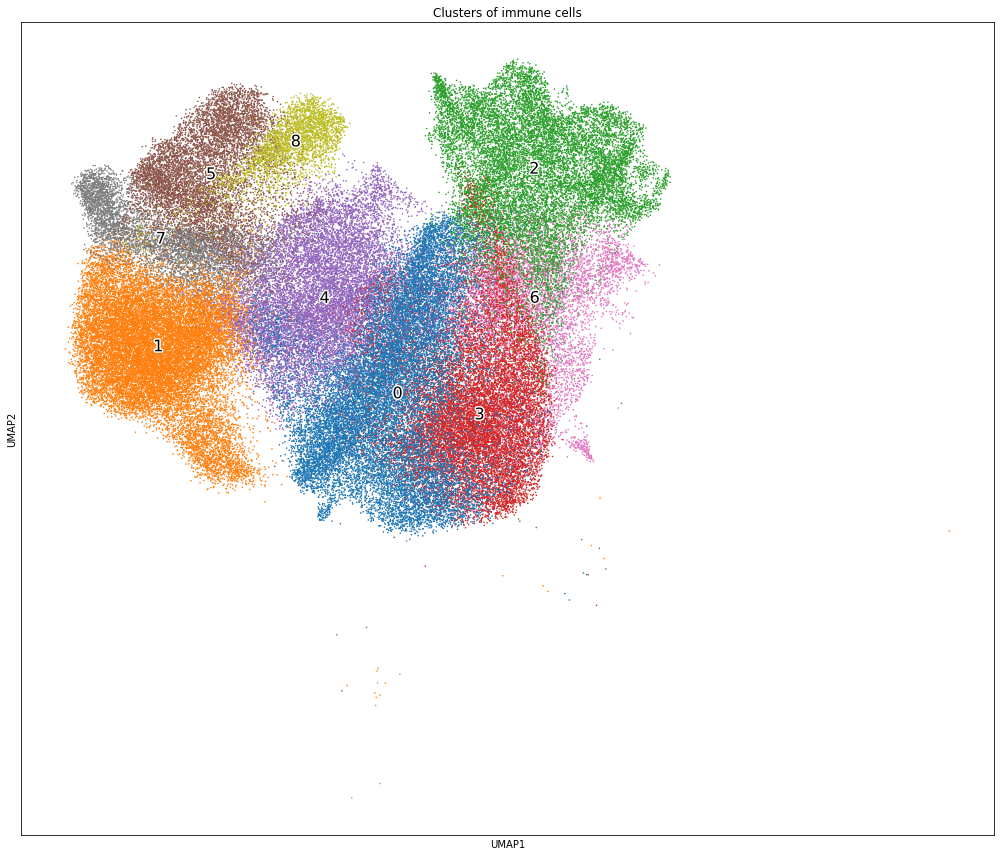

In [41]:
ax = sc.pl.umap(
    imm, 
    color="leiden",
    size=10, 
    title="Clusters of immune cells",
    legend_loc="on data",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()

Merge 1,5,7,8 - TRAM, genes to highlight : FABP4, INHBA, PPARG

Cluster 0 - MoAM, genes to highlight: SPP1, PLA2G7, CCL2, AK5, SIGLEC15, CKB and SLC9B2

Cluster 4 - transitory, no need to highlight the genes.

Cluster 3 - case 1 MoAM: CD163, SLC40A1, MERTK, PLTP, ABCA1

Cluster 6 - MoAM: CLEC10A, F13A1

Cluster 2 - monocytes: FCN1, APOBEC3A, CD300E

In [54]:
imm.obs["cluster"] = imm.obs.leiden.copy()

In [55]:
imm.obs.loc[imm.obs.cluster.isin(["5", "7", "8"]), "cluster"] = "1"

In [56]:
imm.obs.cluster = imm.obs.cluster.astype("str")
imm.obs.cluster.replace({
    "0": "2",
    "2": "3",
    "3": "4",
    "4": "5",
    "9": "7"
}, inplace=True)
# 3>1
# 6>2
# 4>3
# 2>4
# 5>5
# 1>6
imm.obs.cluster.replace({
    "3": "1",
    "6": "2",
    "4": "3",
    "2": "4",
    "1": "6"
}, inplace=True)
imm.obs.cluster = imm.obs.cluster.astype("category")

... storing 'heatmap' as categorical


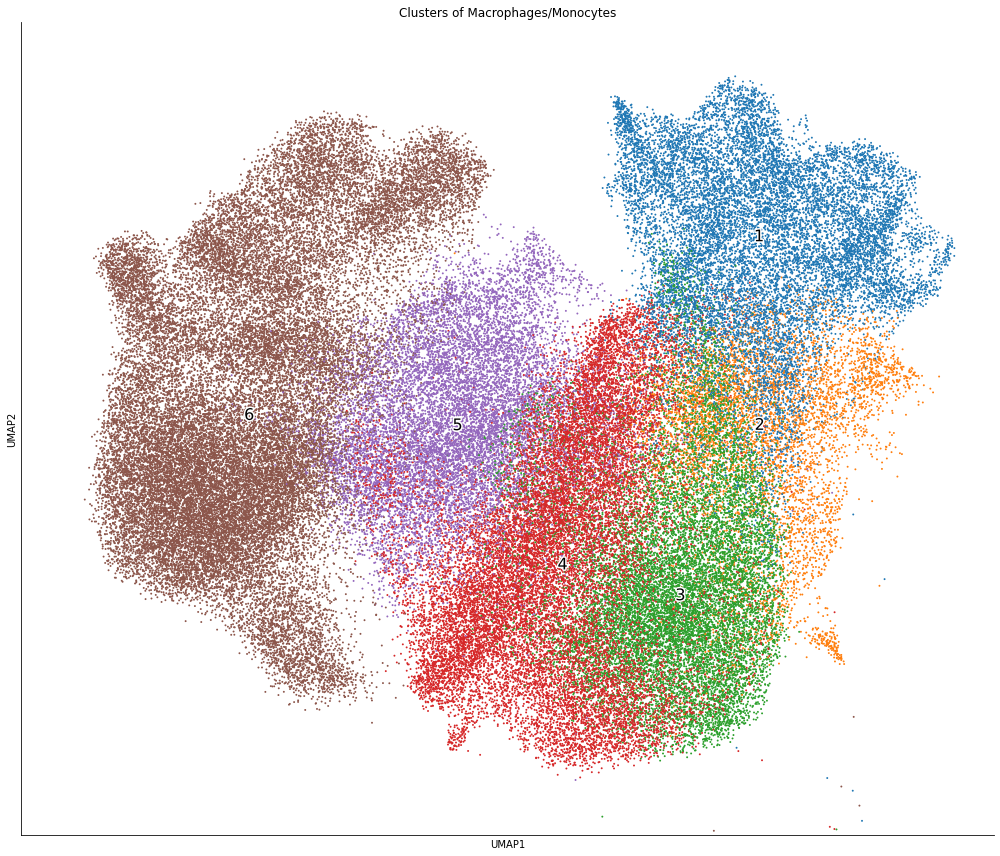

In [57]:
ax = sc.pl.umap(
    imm, 
    color="cluster",
    size=15, 
    frameon=True,
    title="Clusters of Macrophages/Monocytes",
    legend_loc="on data",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.xaxis.set_visible(True)
# ax.xaxis.reset_ticks()
# ax.set_axis_on()
# ax.tick_params(reset=True)
# ax.set_yticks([0, 5, 10, 15])
# ax.set_xticks([0, 5, 10, 15])
ax.set_ylim(bottom=7)
ax.set_xlim(right=5.5)
ax.figure.tight_layout()
ax.figure.savefig("03imm-clusters.pdf")

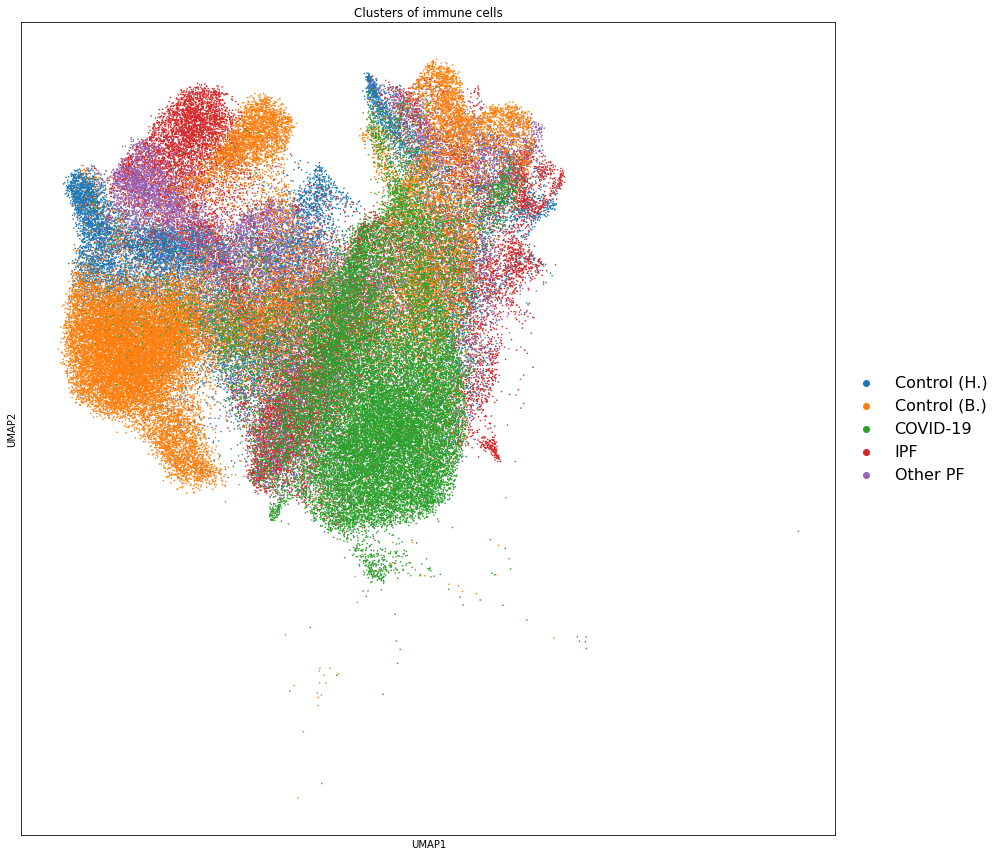

In [29]:
ax = sc.pl.umap(
    imm, 
    color="Diagnosis",
    size=10, 
    title="Clusters of immune cells",
    legend_fontsize=16,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout() 

<AxesSubplot:title={'center':'Leiden by celltype'}>

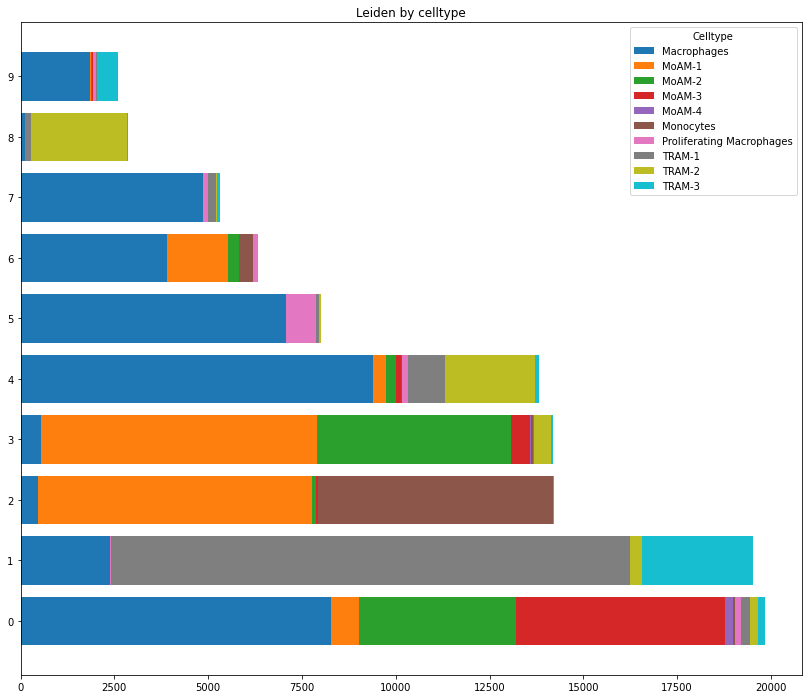

In [30]:
sc_utils.plot_composition(imm, "leiden", "celltype")

In [31]:
imm.obs.Diagnosis.value_counts()

Control (B.)    30762
COVID-19        28784
IPF             19420
Control (H.)    15014
Other PF        12738
Name: Diagnosis, dtype: int64

In [50]:
cat_palette = list(mpl.cm.tab10.colors)
cat_palette[0], cat_palette[2] = cat_palette[2], cat_palette[0]
cat_palette[2], cat_palette[3] = cat_palette[3], cat_palette[2]

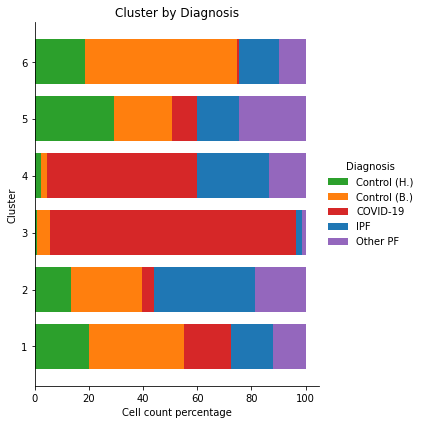

In [58]:
ax = sc_utils.plot_composition(imm, "cluster", "Diagnosis", relative=True, palette=cat_palette)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.figure.set_size_inches((6, 6))
ax.set_ylabel("Cluster")
ax.set_xlabel("Cell count percentage")
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="Diagnosis")
ax.figure.tight_layout()
ax.figure.savefig("03imm-composition-rel.pdf")

In [42]:
imm.shape

(106718, 19202)

In [63]:
imm.raw = imm

In [44]:
sc.tl.rank_genes_groups(imm, "leiden", method="wilcoxon", n_genes=100)
markers = sc_utils.get_markers(imm, "leiden")

In [47]:
markers.cluster = markers.cluster.astype(int)

In [48]:
markers.sort_values(
    "avg_logFC", 
    ascending=False
).groupby("cluster").head(20).sort_values(["cluster", "avg_logFC"], ascending=[True, False])

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
1,0.000000e+00,5.216951,0.657556,0.092488,0.000000e+00,0,SPP1
92,0.000000e+00,4.095394,0.202007,0.016159,0.000000e+00,0,MTRNR2L1
14,0.000000e+00,3.614600,0.420957,0.088759,0.000000e+00,0,CCL2
42,0.000000e+00,3.214540,0.301094,0.050974,0.000000e+00,0,MATK
23,0.000000e+00,3.105864,0.398013,0.099704,0.000000e+00,0,IGKC
6,0.000000e+00,2.503568,0.592910,0.188831,0.000000e+00,0,PLA2G7
81,0.000000e+00,2.183556,0.276486,0.085744,0.000000e+00,0,GALM
26,0.000000e+00,2.077928,0.444405,0.176965,0.000000e+00,0,SDC2
7,0.000000e+00,2.043412,0.684837,0.368985,0.000000e+00,0,LGMN
17,0.000000e+00,2.031985,0.556250,0.254169,0.000000e+00,0,CCL3


In [49]:
imm.write_h5ad("../data/03ipf_projection/03imm.h5ad")

In [50]:
markers.to_csv("../data/03ipf_projection/03imm-markers.csv")

## Genes heatmap

In [59]:
# heatmap group
imm.obs["hm_group"] = imm.obs.Diagnosis.copy()
imm.obs.hm_group = imm.obs.hm_group.astype("str")
imm.obs.loc[imm.obs.Sample_Source == "NU", "hm_group"] = imm.obs.Sample_Name.loc[imm.obs.Sample_Source == "NU"]
imm.obs.hm_group = imm.obs.hm_group.astype("category")
imm.obs.hm_group = imm.obs.hm_group.cat.reorder_categories([
    "Control (H.)", "Donor 1", "Donor 2",
    "Other PF", "IPF", "Case 1", "PMB 1", "PMB 2"
])
imm.obs.hm_group.value_counts()

Donor 2         22335
IPF             17555
Case 1          15334
Control (H.)    14962
Other PF        12693
Donor 1          8401
PMB 1            6561
PMB 2            6274
Name: hm_group, dtype: int64

In [60]:
imm.obs["heatmap"] = imm.obs.cluster.astype(str) + "," + imm.obs.hm_group.astype(str)

In [83]:
genes_of_i = """FABP4
INHBA
PPARG
SPP1
PLA2G7
CCL2
AK5
SIGLEC15
CKB
SLC9B2
CD163
SLC40A1
MERTK
PLTP
ABCA1
MRC1
CLEC10A
F13A1
FCN1
APOBEC3A
CD300E""".split("\n")

In [84]:
markers_expr = []
clusters = list(imm.obs.heatmap.astype(str).unique())
clusters.sort(key=lambda x: (x.split(",")[0], imm.obs.hm_group.cat.categories.get_loc(x.split(",")[1])))
for g in clusters:
    mean_exp = imm.raw.X[(imm.obs.heatmap == g).values, :][:, imm.var_names.isin(genes_of_i)].mean(axis=0).A.reshape(-1)
    markers_expr.append(mean_exp)

In [85]:
markers_expr = pd.DataFrame(markers_expr, columns=imm.var_names[imm.var_names.isin(genes_of_i)], index=clusters)

In [86]:
markers_expr = (markers_expr - markers_expr.min()) / markers_expr.max()

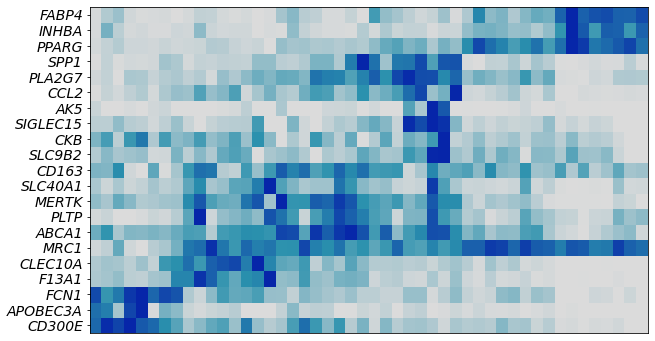

In [87]:
fig, ax = plt.subplots(
    figsize=(10, 6)
)
ax.pcolormesh(markers_expr.loc[:, reversed(genes_of_i)].T.to_numpy(), cmap=sc_utils.expr_colormap())
ax.set_yticks(pd.Series(range(len(genes_of_i))) + 0.5)
ax.set_yticklabels(
    reversed(genes_of_i),
    fontstyle="italic",
    fontsize=14
)
ax.tick_params(bottom=False, labelbottom=False)

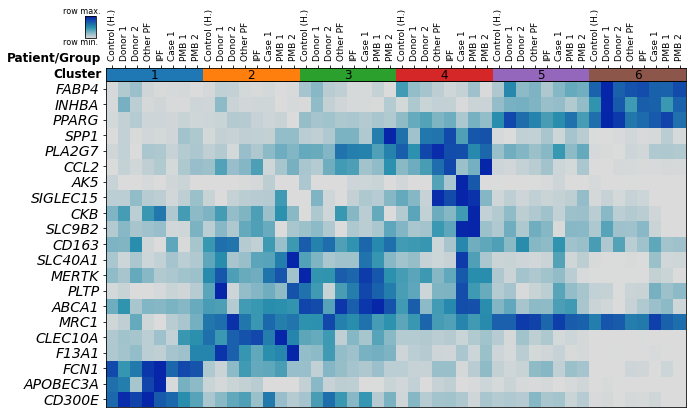

In [88]:
ax0bbox = ax.get_position()
labs = fig.add_axes((ax0bbox.x0, ax0bbox.y1, ax0bbox.width, 0.03), sharex=ax)
labs.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=True, labeltop=True)
clusters = pd.Series(markers_expr.index.str.split(",")).apply(lambda x: x[0]).value_counts().sort_index()
pats = pd.Series(markers_expr.index.str.split(",")).apply(lambda x: x[1])
s = 0
for i, n in enumerate(clusters.index):
    w = clusters[n]
    labs.add_patch(mpl.patches.Rectangle(
        (s, 0), 
        w, 
        1, 
        facecolor=mpl.cm.tab10(i)
    ))
    labs.annotate(
        n, 
        (w / 2 + s, 0.45),
        ha="center",
        va="center",
        color="black",
        fontsize=12
    )
    s += w
# labs.tick_params(pad=20)
labs.set_xticks(pd.Series(range(pats.size)) + 0.5)
labs.set_xticklabels(pats, fontsize=9, rotation=90, va="bottom")
labs.annotate("Patient/Group", (-0.4, 1.5), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)
labs.annotate("Cluster", (-0.4, 0.2), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)

cax = fig.add_axes((0.085, 0.97, 0.015, 0.05))
cax = fig.colorbar(
    mpl.cm.ScalarMappable(norm=None, cmap=sc_utils.expr_colormap()),
    cax=cax,
    ticks=[]
)
cax.ax.annotate("row min.", (-2, 0), va="top", annotation_clip=False, fontsize=8)
cax.ax.annotate("row max.", (-2, 1), va="bottom", annotation_clip=False, fontsize=8)

# available_height = ax.get_position().x0 + 0.02
# move = 0
for i, ax in enumerate(fig.axes):
    p = ax.get_position()
    if i == 2:
        p.x0 += 0.04
        p.x1 += 0.04
        p.y0 -= 0.09
        p.y1 -= 0.09
    else:
        p.x0 += 0.03
        p.x1 += 0.06
        p.y0 -= 0.1
        p.y1 -= 0.1
    ax.set_position(p)

fig.savefig("03imm-markers.pdf")
fig

## Save object with merged clusters

In [89]:
sc.tl.rank_genes_groups(imm, "cluster", method="wilcoxon", n_genes=100)
markers = sc_utils.get_markers(imm, "cluster")

... storing 'heatmap' as categorical


In [90]:
imm.obs.leiden = imm.obs.cluster.copy()
imm.obs.drop(["heatmap", "cluster"], axis=1, inplace=True)

In [91]:
imm.write_h5ad("../data/03ipf_projection/03imm.h5ad")

In [92]:
markers.to_csv("../data/03ipf_projection/03imm-markers.csv")

## Find DEGs between IPF and COVID-19

In [9]:
for c in imm.obs.leiden.cat.categories:
    subset = imm[imm.obs.leiden == c, :]
    subset = subset[subset.obs.Diagnosis.isin(["COVID-19", "IPF"]), :]
    if (subset.obs.Diagnosis.value_counts() > 100).sum() == 2:
        print(f"Computing DEGs for cluster {c}")
        sc.tl.rank_genes_groups(subset, "Diagnosis", method="wilcoxon", n_genes=0)
        degs = sc_utils.get_markers(subset, "Diagnosis")
        degs.loc[degs["pct.2"] > 0.05, :].sort_values(
            "avg_logFC", 
            ascending=False
        ).groupby("cluster").apply(lambda x: x.sort_values(
            ["cluster", "avg_logFC"], 
            ascending=[True, False]
        )).reset_index(drop=True).to_csv(f"03imm-c{c}-degs.csv")

Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 1


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 2


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 3


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 4


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 5


Trying to set attribute `.uns` of view, copying.


Computing DEGs for cluster 6


## Feature plots

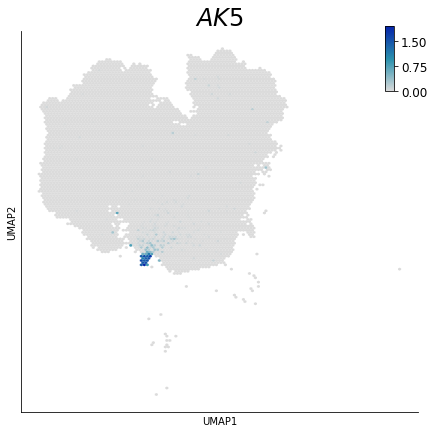

In [6]:
fig = sc_utils.feature_plot(imm, "AK5", gridsize=(120, 80), linewidths=0.05, figsize=(6, 6))
fig.axes[0].set_title("$AK5$", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 0.75, 1.5])
p = fig.axes[1].get_position()
p.x0 -= 0.02
p.x1 -= 0.02
fig.axes[1].set_position(p)
fig.savefig("03imm-ak5.pdf")

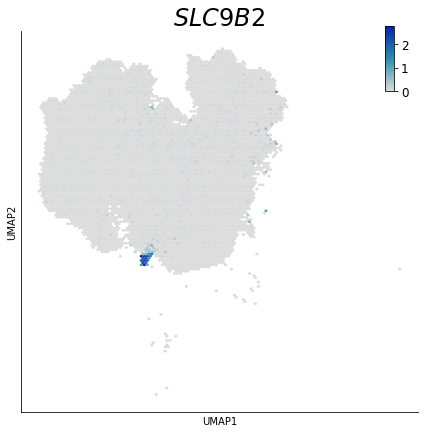

In [9]:
fig = sc_utils.feature_plot(imm, "SLC9B2", gridsize=(120, 80), linewidths=0.05, figsize=(6, 6))
fig.axes[0].set_title("$SLC9B2$", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 1, 2])
p = fig.axes[1].get_position()
p.x0 -= 0.02
p.x1 -= 0.02
fig.axes[1].set_position(p)
fig.savefig("03imm-slc9b2.pdf")